## 하기전 변경사항(읽어보고 이해 안가면 물어봐주세요!)

https://evergreen-port-4ce.notion.site/38cb7911a06744bbba8c711a7a20675b

1. 감자, 고구마, 양파 얘네들에 대한 예측이 마지막날 가격에 의해 결정되는 경우가 많아서, 얘네들을 포함한 상태로 PCA를 돌리기보다 ,감자는 그대로 냅두고 나머지 변수들로만 PCA를 시행해서, 돌려보는걸로 진행을 하는게 나을 것 같음(월요일날 이부분에 대한 질문을 해야할것 같습니다..) 
2. 일단 PCA component개수별로 loss가 나오게끔 코드를 짜놓긴 했는데, 트레인 할때마다 조금씩 달라져서.. (아니면 여기서 Cross Validation을 써야할것 같은데,너무 시간이 오래걸릴것 같으니 걍 test set 결과가 가장 좋은걸 쓰는걸로 갑시다..). 좀 이상한건, pc를 0개일 때무터, 9개일 때까지 해봤는데, pc가 너무 많아지면 성능이 떨어지는 건 확인을 했는데,  PCA componetn가 1개일때 값이 가장잘나온다거나 그런경우가 있음...-> 이경우 어떡하지..? 일단은 예측일을 10일로 바꾸어봤음..(혹시 다른작물들 10일 예측결과가 좀안좋으면 14일도 한번해보면 좋을것 같아요, 양파10일 예측을 한번 해보고, 결과를 알려주세용!!)
3. 농산물을 추가적으로 찾을 필요는 없어 보입니다.
+PC개수별 loss 찾는거가 생각보다 오래걸려서,  현재 상추, 깻잎, 감자, 고구마, 양파 있는데, 상추 두 종류랑 깻잎은, 제가 하겠습니다.
4. GPU가 돌아갈때는, 3-fold Cross Validation하는데 약 55분정도걸리는데, 양파하나만 3-fold CV해보고 괜찮다싶으면 그냥 CV안하고 해도 될것같습니당.
(GPU 안되면,3-fold없이 그냥 test결과로 봐도 될듯 합니다.왼쪽 목차로 구분해놨어용)
GPU 가 안돌아가면, CV없이 한 55분정도 걸립니당.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') ## 이작업을 해줘야 드라이브에 있는 엑셀파일을 열 수 있음.

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 기본함수(스케일링, 모델 등등)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM,GRU
from keras.models import load_model
from keras import optimizers
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import os

def featurescale(X_train,X_test,y_train,y_test):
    x_scaler=MinMaxScaler() ## Min-max Scale 진행
    x_scaler.fit(X_train)
    X_train=x_scaler.transform(X_train) ## X_train을 기준으로 하고 Scaling 진행
    X_test=x_scaler.transform(X_test)
    y_scaler=MinMaxScaler()
    y_train=y_train.reshape(-1,1)
    y_test=y_test.reshape(-1,1)
    y_scaler.fit(y_train)
    y_train=y_scaler.transform(y_train)
    y_test=y_scaler.transform(y_test)
    return X_train,X_test, y_train,y_test,x_scaler, y_scaler

def PCAtransform(X_train,X_test,info):
    pca = PCA(n_components=info) ## X_train을 기준으로 하고 Scaling 진행
    pca.fit(X_train)
    pca_train = pca.transform(X_train)
    pca_test=pca.transform(X_test)
    n_components=(pca.n_features_in_)
    return pca, pca_train,pca_test, n_components

def make_dataset(data, label, to_predict,window_size=25,output_size=10):
    feature_list = []
    label_list = []
    for i in range(len(data)):
        end_ix = i + window_size
        out_end_ix = end_ix + output_size-1
        if out_end_ix+to_predict > len(data):
            break
        feature_list.append(np.array(data[i:i+window_size,:]))
        label_list.append(np.array(label[i+window_size-1+to_predict:out_end_ix+to_predict]))
    return np.array(feature_list), np.array(label_list)
def Lstmmodel(x_train,y_train,x_val,y_val):
  model = Sequential()
  model.add(LSTM(128, 
                input_shape=(x_train.shape[1], x_train.shape[2]), 
                activation='tanh', 
                return_sequences=False)
            )
  model.add(Dropout(0.01))
  model.add(Dense(10))
  sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
  adm=tf.keras.optimizers.Adam(lr=0.00025)
  model.compile(loss='mean_squared_error', optimizer=adm)
  early_stop = EarlyStopping(monitor='val_loss', patience=15)
  model.summary()
  model_path = '/content/drive/MyDrive/Colab Notebooks/model' ##모델 저장, 딱히 쓰지는 않음..
  filename = os.path.join(model_path, 'tmp_checkpoint.h5')
  checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
 
  history = model.fit(x_train, y_train, 
                                      epochs=200, 
                                      batch_size=16,
                                      validation_data=(x_val,y_val),
                       callbacks=[ early_stop,checkpoint] 
                                      )
  opt=load_model('/content/drive/MyDrive/Colab Notebooks/model/tmp_checkpoint.h5')
  return model
def GruModel(x_train,y_train,x_val,y_val):
    model = Sequential()
    model.add(GRU(128, 
                input_shape=(x_train.shape[1], x_train.shape[2]), 
                activation='tanh', 
                return_sequences=False)
            )
    model.add(Dropout(0.01))

    model.add(Dense(10))
    import os
    sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
    adm=tf.keras.optimizers.Adam(lr=0.00025)
    model.compile(loss='mean_squared_error', optimizer=adm)
    early_stop = EarlyStopping(monitor='val_loss', patience=15)
    model.summary()
    model_path = '/content/drive/MyDrive/Colab Notebooks/grumodel'
    filename = os.path.join(model_path, 'tmp_checkpoint.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    history = model.fit(x_train, y_train, 
                                      epochs=200, 
                                      batch_size=16,
                                      validation_data=(x_val,y_val),
                                      callbacks=[ early_stop,checkpoint])
    opt=load_model('/content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5')
    return model
from sklearn.metrics import mean_squared_error, mean_absolute_error

def confirm_result(y_pred,test_label):
    RMSE=mean_squared_error(y_pred,test_label)
    MAE=mean_absolute_error(y_pred,test_label)
    #print("RMSE of PCA GRU : {} ".format(RMSE))
    #print("MAE of PCA GRU :{}".format(MAE))
    return RMSE

## 전처리

In [ ]:

df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data_ver7.csv")
df.head()
#df=df.drop('연도',1) ##연도 column dropf
df=df.drop('시점',1)
df=df.drop('청상추 가격',1)
df=df.drop('적상추 가격',1)
df=df.drop('감자 가격',1)
df=df.drop('고구마 가격',1)
df=df.drop('양파 가격',1)
#df=df.drop('깻잎 가격',1)

print(df.columns)
features=(df.columns)
#print(df)
print(len(features))
from sklearn.preprocessing import MinMaxScaler
data=df.to_numpy()

Index(['깻잎 가격', '강원도 강수량(mm)', '강원도 평균기온(℃)', '강원도 평균습도(%rh)', '강원도 평균풍속(m/s)',
       '광주 강수량(mm)', '광주 평균기온(℃)', '광주 평균습도(%rh)', '광주 평균풍속(m/s)',
       '대구 강수량(mm)', '대구 평균기온(℃)', '대구 평균습도(%rh)', '대구 평균풍속(m/s)',
       '대전 강수량(mm)', '대전 평균기온(℃)', '대전 평균습도(%rh)', '대전 평균풍속(m/s)',
       '부산 강수량(mm)', '부산 평균기온(℃)', '부산 평균습도(%rh)', '부산 평균풍속(m/s)',
       '서울 강수량(mm)', '서울 평균기온(℃)', '서울 평균습도(%rh)', '서울 평균풍속(m/s)', '유가_평균',
       'LNG', ' 옥수수', '대두박 ', '대두', '가스오일', '귀리', 'KOSPI', '콜금리'],
      dtype='object')
34


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


## Model prediction-3fold CV(전체 다)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

x=data[:,0:]
y=data[:,0]

i=0
loss=[]
pclstmloss=[]
gruloss=[]
pcgruloss=[]

TRAIN_SIZE=4400 ##train size = 약 4500 (windowing 때문에 정확히는 4470개)
x_train=x[:TRAIN_SIZE,:]
x_test=x[TRAIN_SIZE:,:]
y_train=y[:TRAIN_SIZE]
y_test=y[TRAIN_SIZE:]
#pclstm_loss=np.zeros(to_test)
#pcgru_loss=np.zeros(to_test)
normal=[0,0]
 ## 3fold cross validation: GPU돌아갈때 약 1시간 걸림 (전체 다. ) 


x_train,x_test,y_train,y_test,x_scaler,y_scaler=featurescale(x_train,x_test,y_train,y_test) ##각각 train기준으로 scaling

dayafter=0
VAL_NUM=300
nonpc_train,y_train=make_dataset(x_train,y_train,to_predict=dayafter) ##일반모델 train set을 LSTM input 형태에 맞게끔
nonpc_test,y_test=make_dataset(x_test,y_test,to_predict=dayafter)## 일반모델 test set LSTM input 형태에 맞게끔
print(nonpc_train.shape)
y_train=y_train.reshape(y_train.shape[0],y_train.shape[1])
nonpc_te=nonpc_test
print(nonpc_train.shape)
print(nonpc_test.shape)
nonpc_val=nonpc_test[:VAL_NUM,:,:]
print(nonpc_val.shape)
nonpc_test=nonpc_test[VAL_NUM:,:,:]
y_test=y_test.reshape(y_test.shape[0],y_test.shape[1])
y_val=y_test[:VAL_NUM,:]  ##validation 기준으로 validation loss가 15번동안 줄지않으면 멈춤. 300개로 설정
y_test=y_test[VAL_NUM:,:]


#LSTMmodel=Lstmmodel(nonpc_train,y_train,nonpc_val,y_val) ##일반모델 LSTM
#LSTMpred=LSTMmodel.predict(nonpc_test)


#GRUmodel=GruModel(nonpc_train,y_train,nonpc_val,y_val) ##일반모델 GRU
#GRUpred=GRUmodel.predict(nonpc_test)


pca,pca_train,pca_test,n_components=PCAtransform(x_train[:,1:],x_test[:,1:],0.9)   ## train기준으로PCA ->0.9 이것만조절해주면서 확인? 
#pc_train,_=make_dataset(pca_train,y_train,to_predict=dayafter) ##PCA를 LSTM input 형태에 맞게끔
#pc_test,_=make_dataset(pca_test,y_test,to_predict=dayafter) ## LSTM input 형태에 맞게끔


#pc_train=(np.concatenate([nonpc_train[:,:,0].reshape(nonpc_train.shape[0],nonpc_train.shape[1],1),pc_train ], -1))
#pc_test=(np.concatenate([nonpc_te[:,:,0].reshape(nonpc_te.shape[0],nonpc_te.shape[1],1),pc_test ], -1))
#pc_val=pc_test[:VAL_NUM,:,:]##validation 기준으로 validation loss가 15번동안 줄지않으면 멈춤. 300개로 설정
#pc_test=pc_test[VAL_NUM:,:,:]

#print(pc_train.shape)
#pcGRU=GruModel(pc_train,y_train,pc_val,y_val) ##PCA +GRU
#pcLSTM=Lstmmodel(pc_train,y_train,pc_val,y_val)##PCA +LSTM
#pcLSTMpred=pcLSTM.predict(pc_test)
#pcGRUpred=pcGRU.predict(pc_test)



(4367, 25, 34)
(4367, 25, 34)
(1046, 25, 34)
(300, 25, 34)


In [ ]:
print(pca_train.shape)

(4400, 8)


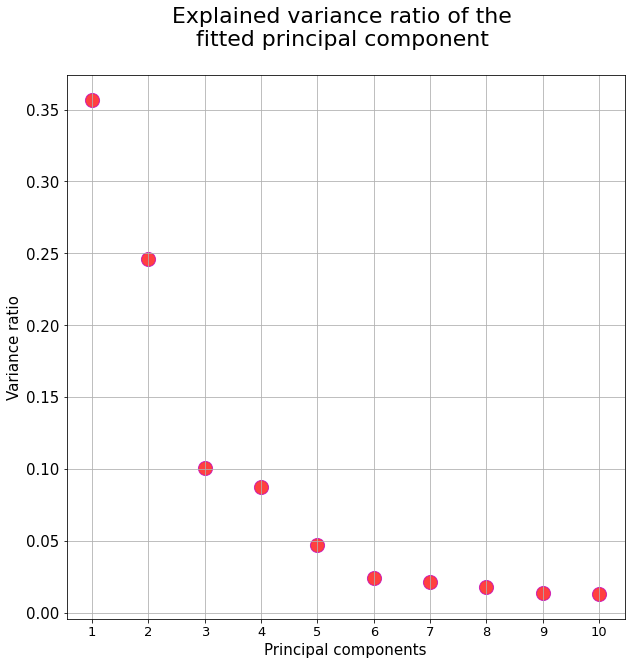

In [ ]:
from sklearn.decomposition import PCA
plt.figure(figsize=(10,10))
plt.scatter(x=[i+1 for i in range(10)],
           y=pca.explained_variance_ratio_[:10],
           s=200, alpha=0.75, c='red', edgecolor='m')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component \n",fontsize=22)
plt.xlabel("Principal components", fontsize=15)
plt.xticks([i+1 for i in range(10)], fontsize=13)
plt.yticks(fontsize=15)
plt.ylabel("Variance ratio",fontsize=15)
plt.show()

## PCGRU 깻잎 1일 10일

Text(0.5, 1.0, 'Sesame Leaf estimation after 1 day')

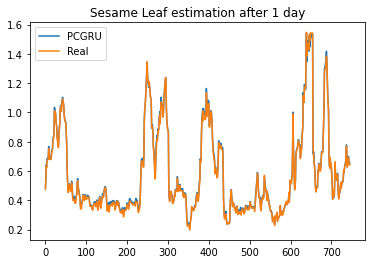

In [ ]:
#LSTMpred[:,0]
#GRUpred[:,0]
#pcLSTMpred[:,0]
#pcGRUpred[:,0]
range_history=np.arange(0,len(pc_test),1)
range_future=np.arange(0,len(pc_test[:]),1)
plt.plot(range_history,pcGRUpred[:,0],label="PCGRU")
plt.plot(range_future,y_test[:,0],label="Real")
plt.legend()
plt.title("Sesame Leaf estimation after 1 day")

Text(0.5, 1.0, 'Sesame Leaf estimation after 10 day')

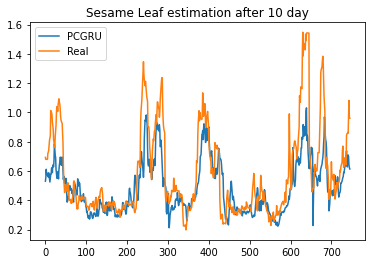

In [ ]:
plt.plot(range_history,pcGRUpred[:,9],label="PCGRU")
plt.plot(range_future,y_test[:,9],label="Real")
plt.legend()
plt.title("Sesame Leaf estimation after 10 day")

##PCLSTM 깻잎 1일, 10일

Text(0.5, 1.0, 'Sesame Leaf estimation after 1 day')

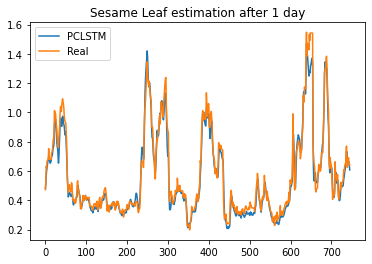

In [ ]:
range_history=np.arange(0,len(pc_test),1)
range_future=np.arange(0,len(pc_test[:]),1)
plt.plot(range_history,pcLSTMpred[:,0],label="PCLSTM")
plt.plot(range_future,y_test[:,0],label="Real")
plt.legend()
plt.title("Sesame Leaf estimation after 1 day")

Text(0.5, 1.0, 'Sesame Leaf estimation after 10 day')

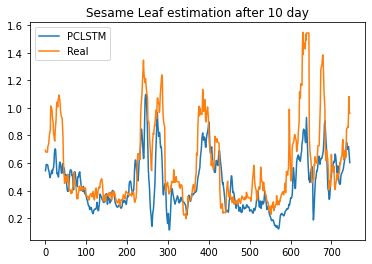

In [ ]:
plt.plot(range_history,pcLSTMpred[:,9],label="PCLSTM")
plt.plot(range_future,y_test[:,9],label="Real")
plt.legend()
plt.title("Sesame Leaf estimation after 10 day")

## GRU 깻잎 1일, 10일

Text(0.5, 1.0, 'Sesame Leaf estimation after 1 day')

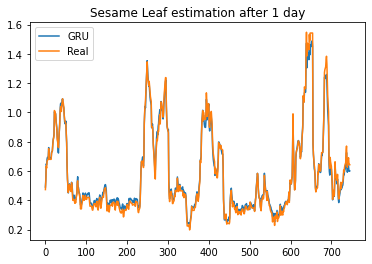

In [ ]:
range_history=np.arange(0,len(pc_test),1)
range_future=np.arange(0,len(pc_test[:]),1)
plt.plot(range_history,GRUpred[:,0],label="GRU")
plt.plot(range_future,y_test[:,0],label="Real")
plt.legend()
plt.title("Sesame Leaf estimation after 1 day")

Text(0.5, 1.0, 'Sesame Leaf estimation after 10 day')

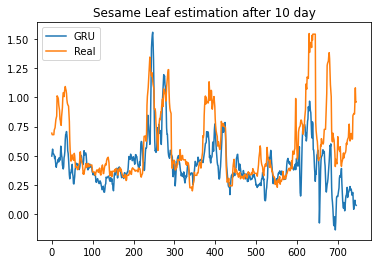

In [ ]:
range_history=np.arange(0,len(pc_test),1)
range_future=np.arange(0,len(pc_test[:]),1)
plt.plot(range_history,GRUpred[:,9],label="GRU")
plt.plot(range_future,y_test[:,9],label="Real")
plt.legend()
plt.title("Sesame Leaf estimation after 10 day")

## LSTM 꺳잎 1일 10일

Text(0.5, 1.0, 'Sesame Leaf estimation after 1 day')

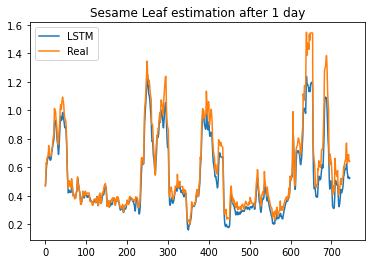

In [ ]:
range_history=np.arange(0,len(pc_test),1)
range_future=np.arange(0,len(pc_test[:]),1)
plt.plot(range_history,LSTMpred[:,0],label="LSTM")
plt.plot(range_future,y_test[:,0],label="Real")
plt.legend()
plt.title("Sesame Leaf estimation after 1 day")

Text(0.5, 1.0, 'Sesame Leaf estimation after 10 day')

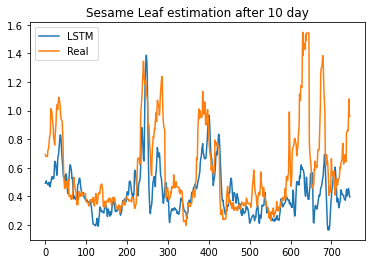

In [ ]:
range_history=np.arange(0,len(pc_test),1)
range_future=np.arange(0,len(pc_test[:]),1)
plt.plot(range_history,LSTMpred[:,9],label="LSTM")
plt.plot(range_future,y_test[:,9],label="Real")
plt.legend()
plt.title("Sesame Leaf estimation after 10 day")

In [ ]:
normal ##PCA 처리 안한애들 LOSS


[0.017326060864667984, 0.008476322779288347]

In [ ]:
print(pcgru_loss)
print(pclstm_loss)

[0.00513817 0.00529351 0.00608458 0.00525898 0.0053973  0.00603722
 0.00657675 0.00674923 0.00630662 0.00609903]
[0.00565333 0.00614142 0.0061038  0.00618597 0.00647332 0.00811412
 0.00993924 0.0111606  0.01539994 0.0196809 ]


#  일반 Train Test(CV 없는 버젼)


In [ ]:
x=data[:,0:]
y=data[:,0]

i=0
loss=[]
pclstmloss=[]
gruloss=[]
pcgruloss=[]

TRAIN_SIZE=4400 ##train size = 약 4500 (windowing 때문에 정확히는 4470개)
x_train=x[:TRAIN_SIZE,:]
x_test=x[TRAIN_SIZE:,:]
y_train=y[:TRAIN_SIZE]
y_test=y[TRAIN_SIZE:]
print(x.shape)
to_test=12
pclstm_loss=np.zeros(to_test)
pcgru_loss=np.zeros(to_test)
normal=[0,0]
#tscv = TimeSeriesSplit(n_splits=3,test_size=900) ## 3fold cross validation: GPU돌아갈때 약 1시간 걸림 (전체 다. ) 

x_train,x_test,y_train,y_test,x_scaler,y_scaler=featurescale(x_train,x_test,y_train,y_test) ##각각 train기준으로 scaling

dayafter=0
VAL_NUM=300
nonpc_train,y_train=make_dataset(x_train,y_train,to_predict=dayafter) ##일반모델 train set을 LSTM input 형태에 맞게끔
nonpc_test,y_test=make_dataset(x_test,y_test,to_predict=dayafter)## 일반모델 test set LSTM input 형태에 맞게끔
print(nonpc_train.shape)
y_train=y_train.reshape(y_train.shape[0],y_train.shape[1])
nonpc_te=nonpc_test
nonpc_val=nonpc_test[:VAL_NUM,:,:]
nonpc_test=nonpc_test[VAL_NUM:,:,:]
y_test=y_test.reshape(y_test.shape[0],y_test.shape[1])
y_val=y_test[:VAL_NUM,:]  ##validation 기준으로 validation loss가 15번동안 줄지않으면 멈춤. 300개로 설정
y_test=y_test[VAL_NUM:,:]
print(y_train.shape)
print(y_test.shape)

model=Lstmmodel(nonpc_train,y_train,nonpc_val,y_val) ##일반모델 LSTM
y_pred=model.predict(nonpc_test)


GRmodel=GruModel(nonpc_train,y_train,nonpc_val,y_val) ##일반모델 GRU
GRUpred=GRmodel.predict(nonpc_test)
RMSE=confirm_result(y_pred.flatten(),y_test.flatten())
gruRMSE=confirm_result(GRUpred.flatten(),y_test.flatten())
normal[0]+=RMSE
normal[1]+=gruRMSE
for i in range(to_test):
  pca,pca_train,pca_test,n_components=PCAtransform(x_train[:,1:],x_test[:,1:],i)   ## train기준으로PCA ->0.9 이것만조절해주면서 확인? 


  pc_train,_=make_dataset(pca_train,y_train,to_predict=dayafter) ##PCA를 LSTM input 형태에 맞게끔
  pc_test,_=make_dataset(pca_test,y_test,to_predict=dayafter) ## LSTM input 형태에 맞게끔


  pc_train=(np.concatenate([nonpc_train[:,:,0].reshape(nonpc_train.shape[0],nonpc_train.shape[1],1),pc_train ], -1))
  pc_test=(np.concatenate([nonpc_te[:,:,0].reshape(nonpc_te.shape[0],nonpc_te.shape[1],1),pc_test ], -1))
  pc_val=pc_test[:VAL_NUM,:,:]##validation 기준으로 validation loss가 15번동안 줄지않으면 멈춤. 300개로 설정
  pc_test=pc_test[VAL_NUM:,:,:]

  print(pc_train.shape)
  pcGRU=GruModel(pc_train,y_train,pc_val,y_val) ##PCA +GRU
  model2=Lstmmodel(pc_train,y_train,pc_val,y_val)##PCA +LSTM
  pcy_pred=model2.predict(pc_test)
  pcGRUpred=pcGRU.predict(pc_test)
  pcRMSE=confirm_result(pcy_pred.flatten(),y_test.flatten())
  pclstmloss.append(pcRMSE)
  pcGRURMSE=confirm_result(pcGRUpred.flatten(),y_test.flatten())
  pcgru_loss[i]+=pcGRURMSE
  pclstm_loss[i]+=pcRMSE

(5479, 34)
(4370, 25, 34)
(4370, 7)
(749, 7)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               83456     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 84,359
Trainable params: 84,359
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
274/274 [==============================] - ETA: 0s - loss: 0.0208
Epoch 1: val_loss improved from inf to 0.01229, saving model to /content/drive/MyDrive/Colab Notebooks/model/tmp_checkpoint.h5
274/274 [==============================] - 24s 64ms/step - loss: 0.0208 - val_loss: 0.0123
Epoch 2/200
272/274 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 2: val_loss improved from 0.01229 to 0.00960, saving model to /content/drive/MyDrive/Colab Notebooks/model/tmp_checkpoint.h5
274/274 [==============================] - 13s 49ms/step - loss: 0.0085 - val_loss: 0.0096
Epoch 3/200
272/274 [============================>.] - ETA: 0s - loss: 0.0066
Epoch 3: val_loss improved from 0.00960 to 0.00931, saving model to /content/drive/MyDrive/Colab Notebooks/model/tmp_checkpoint.h5
274/274 [==============================] - 8s 29ms/step - loss: 0.0066 - val_loss: 0.0093
Epoch 4/200
272/274 [============================>.] - ETA: 0s - loss: 0.0057
Epoch 4: val_loss improved 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128)               50304     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                                 
Total params: 51,207
Trainable params: 51,207
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


272/274 [============================>.] - ETA: 0s - loss: 0.0189
Epoch 1: val_loss improved from inf to 0.00792, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 9s 24ms/step - loss: 0.0189 - val_loss: 0.0079
Epoch 2/200
272/274 [============================>.] - ETA: 0s - loss: 0.0064
Epoch 2: val_loss improved from 0.00792 to 0.00631, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 22ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 3/200
273/274 [============================>.] - ETA: 0s - loss: 0.0056
Epoch 3: val_loss improved from 0.00631 to 0.00598, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 22ms/step - loss: 0.0056 - val_loss: 0.0060
Epoch 4/200
272/274 [============================>.] - ETA: 0s - loss: 0.0052
Epoch 4: val_loss did not improv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 2)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 128)               50688     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 903       
                                                                 
Total params: 51,591
Trainable params: 51,591
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


274/274 [==============================] - ETA: 0s - loss: 0.0206
Epoch 1: val_loss improved from inf to 0.00823, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 7s 21ms/step - loss: 0.0206 - val_loss: 0.0082
Epoch 2/200
274/274 [==============================] - ETA: 0s - loss: 0.0065
Epoch 2: val_loss improved from 0.00823 to 0.00641, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 5s 19ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 3/200
274/274 [==============================] - ETA: 0s - loss: 0.0055
Epoch 3: val_loss improved from 0.00641 to 0.00554, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 5s 20ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 4/200
272/274 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 4: val_loss improved from 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 3)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 128)               51072     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 7)                 903       
                                                                 
Total params: 51,975
Trainable params: 51,975
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


272/274 [============================>.] - ETA: 0s - loss: 0.0215
Epoch 1: val_loss improved from inf to 0.00761, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 8s 21ms/step - loss: 0.0214 - val_loss: 0.0076
Epoch 2/200
273/274 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 2: val_loss improved from 0.00761 to 0.00696, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 5s 19ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 3/200
272/274 [============================>.] - ETA: 0s - loss: 0.0055
Epoch 3: val_loss improved from 0.00696 to 0.00642, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 5s 19ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 4/200
272/274 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 4: val_loss improved from 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 4)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 128)               51456     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 7)                 903       
                                                                 
Total params: 52,359
Trainable params: 52,359
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


272/274 [============================>.] - ETA: 0s - loss: 0.0252
Epoch 1: val_loss improved from inf to 0.00883, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 8s 21ms/step - loss: 0.0252 - val_loss: 0.0088
Epoch 2/200
274/274 [==============================] - ETA: 0s - loss: 0.0069
Epoch 2: val_loss improved from 0.00883 to 0.00632, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 21ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 3/200
272/274 [============================>.] - ETA: 0s - loss: 0.0057
Epoch 3: val_loss improved from 0.00632 to 0.00559, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 21ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 4/200
273/274 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 4: val_loss improved from 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 5)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 128)               51840     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 7)                 903       
                                                                 
Total params: 52,743
Trainable params: 52,743
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


273/274 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 1: val_loss improved from inf to 0.00782, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 9s 24ms/step - loss: 0.0228 - val_loss: 0.0078
Epoch 2/200
272/274 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 2: val_loss improved from 0.00782 to 0.00624, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 23ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 3/200
272/274 [============================>.] - ETA: 0s - loss: 0.0054
Epoch 3: val_loss improved from 0.00624 to 0.00615, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 22ms/step - loss: 0.0054 - val_loss: 0.0061
Epoch 4/200
274/274 [==============================] - ETA: 0s - loss: 0.0047
Epoch 4: val_loss improved from 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 6)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 128)               52224     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 7)                 903       
                                                                 
Total params: 53,127
Trainable params: 53,127
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


272/274 [============================>.] - ETA: 0s - loss: 0.0210
Epoch 1: val_loss improved from inf to 0.00743, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 10s 25ms/step - loss: 0.0210 - val_loss: 0.0074
Epoch 2/200
273/274 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 2: val_loss improved from 0.00743 to 0.00668, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 23ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 3/200
273/274 [============================>.] - ETA: 0s - loss: 0.0052
Epoch 3: val_loss improved from 0.00668 to 0.00571, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 22ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 4/200
273/274 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 4: val_loss improved from

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 7)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 128)               52608     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 7)                 903       
                                                                 
Total params: 53,511
Trainable params: 53,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


274/274 [==============================] - ETA: 0s - loss: 0.0254
Epoch 1: val_loss improved from inf to 0.00913, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 8s 23ms/step - loss: 0.0254 - val_loss: 0.0091
Epoch 2/200
273/274 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 2: val_loss improved from 0.00913 to 0.00741, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 22ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 3/200
272/274 [============================>.] - ETA: 0s - loss: 0.0054
Epoch 3: val_loss improved from 0.00741 to 0.00582, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 23ms/step - loss: 0.0054 - val_loss: 0.0058
Epoch 4/200
272/274 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 4: val_loss improved from 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 8)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 128)               52992     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 7)                 903       
                                                                 
Total params: 53,895
Trainable params: 53,895
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


274/274 [==============================] - ETA: 0s - loss: 0.0223
Epoch 1: val_loss improved from inf to 0.00744, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 9s 24ms/step - loss: 0.0223 - val_loss: 0.0074
Epoch 2/200
274/274 [==============================] - ETA: 0s - loss: 0.0066
Epoch 2: val_loss improved from 0.00744 to 0.00599, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 23ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 3/200
273/274 [============================>.] - ETA: 0s - loss: 0.0054
Epoch 3: val_loss improved from 0.00599 to 0.00587, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 23ms/step - loss: 0.0053 - val_loss: 0.0059
Epoch 4/200
274/274 [==============================] - ETA: 0s - loss: 0.0047
Epoch 4: val_loss did not improv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 9)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 128)               53376     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 7)                 903       
                                                                 
Total params: 54,279
Trainable params: 54,279
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


273/274 [============================>.] - ETA: 0s - loss: 0.0216
Epoch 1: val_loss improved from inf to 0.00716, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 9s 26ms/step - loss: 0.0216 - val_loss: 0.0072
Epoch 2/200
272/274 [============================>.] - ETA: 0s - loss: 0.0062
Epoch 2: val_loss improved from 0.00716 to 0.00629, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 22ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 3/200
274/274 [==============================] - ETA: 0s - loss: 0.0051
Epoch 3: val_loss improved from 0.00629 to 0.00567, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 22ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 4/200
273/274 [============================>.] - ETA: 0s - loss: 0.0046
Epoch 4: val_loss improved from 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 10)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 128)               53760     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 7)                 903       
                                                                 
Total params: 54,663
Trainable params: 54,663
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


274/274 [==============================] - ETA: 0s - loss: 0.0212
Epoch 1: val_loss improved from inf to 0.00745, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 9s 24ms/step - loss: 0.0212 - val_loss: 0.0074
Epoch 2/200
272/274 [============================>.] - ETA: 0s - loss: 0.0064
Epoch 2: val_loss improved from 0.00745 to 0.00611, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 21ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 3/200
274/274 [==============================] - ETA: 0s - loss: 0.0053
Epoch 3: val_loss improved from 0.00611 to 0.00547, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 21ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 4/200
272/274 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 4: val_loss improved from 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 11)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 128)               54144     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 7)                 903       
                                                                 
Total params: 55,047
Trainable params: 55,047
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


272/274 [============================>.] - ETA: 0s - loss: 0.0241
Epoch 1: val_loss improved from inf to 0.00835, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 9s 22ms/step - loss: 0.0240 - val_loss: 0.0084
Epoch 2/200
273/274 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 2: val_loss improved from 0.00835 to 0.00646, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 21ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 3/200
274/274 [==============================] - ETA: 0s - loss: 0.0055
Epoch 3: val_loss improved from 0.00646 to 0.00627, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 21ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 4/200
273/274 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 4: val_loss improved from 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(4370, 25, 12)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 128)               54528     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 7)                 903       
                                                                 
Total params: 55,431
Trainable params: 55,431
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


272/274 [============================>.] - ETA: 0s - loss: 0.0241
Epoch 1: val_loss improved from inf to 0.00871, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 8s 22ms/step - loss: 0.0240 - val_loss: 0.0087
Epoch 2/200
273/274 [============================>.] - ETA: 0s - loss: 0.0065
Epoch 2: val_loss improved from 0.00871 to 0.00644, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 20ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 3/200
272/274 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 3: val_loss improved from 0.00644 to 0.00606, saving model to /content/drive/MyDrive/Colab Notebooks/grumodel/tmp_checkpoint.h5
274/274 [==============================] - 6s 20ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 4/200
272/274 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 4: val_loss improved from 

In [ ]:
print(normal)

[0.011529471395065612, 0.006758773655231084]


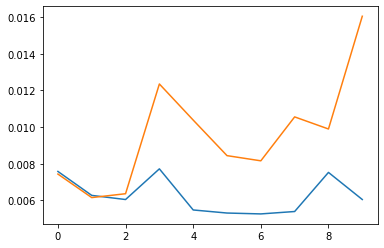

In [ ]:
plt.plot((pcgru_loss))
plt.plot(pclstm_loss)

In [ ]:
print(pcgru_loss)
print(pclstm_loss)

[0.00757696 0.0062692  0.0060435  0.00771864 0.00547337 0.00530578
 0.00525765 0.0053888  0.00752457 0.00604437]
[0.00743407 0.00614921 0.00636079 0.01235422 0.01038317 0.00844063
 0.00815754 0.01055649 0.00989596 0.01605387]


In [ ]:
pca,pca_train,pca_test,n_components=PCAtransform(x_train[:,1:],x_test[:,1:],0.8)
print(pca_train.shape)

In [ ]:
print(y_pred.shape)
#print("PCLSTM per component number :{}".format(pcloss))
#print("LSTM :{}".format(np.sum(loss)))
#print("GRU :{}".format(np.sum(gruloss)))
#print("PCAGRU per component number :{}".format(pcgruloss))

loss=0
pcloss=0
gru=0
pcgru=0
print("LSTM")
for i in range(7):
  day1pre=(y_pred[:,i])
  day1test=(y_test[:,i])
  print(confirm_result(day1pre,day1test))
  loss+=confirm_result(day1pre,day1test)
print("Overall loss:{}".format(loss))
print()
print("PCALSTM")
for i in range(7):
  day1pre=(pcy_pred[:,i])
  day1test=(y_test[:,i])
  print(confirm_result(day1pre,day1test))
  pcloss+=confirm_result(day1pre,day1test)
print("Overall loss:{}".format(pcloss))
print()
print("GRU")
for i in range(7):
  day1pre=(GRUpred[:,i])
  day1test=(y_test[:,i])
  print(confirm_result(day1pre,day1test))
  gru+=confirm_result(day1pre,day1test)
print("Overall loss:{}".format(gru))
print()
#loss=0
print("PCAGRU")
for i in range(7):  
  day1_pred=pcGRUpred[:,i]
  day1test=y_test[:,i]
  print(confirm_result(day1_pred,day1test))
  pcgru+=confirm_result(day1_pred,day1test)
print("Overall loss:{}".format(pcgru))

(649, 7)
LSTM
0.0003085806146311851
0.0020730501752085134
0.004885300751383588
0.007610173774246118
0.011550296803143201
0.015292470783824418
0.016934644145702567
Overall loss:0.058654517048139586

PCALSTM
6.755608696140223e-05
0.001291564821518719
0.003006387419839376
0.0050588822887548
0.006914696923213929
0.008605734773159285
0.010063457945722235
Overall loss:0.035008280259169744

GRU
0.00010161874466016807
0.001198238317173391
0.0036833631170477355
0.005745794434515171
0.008051244325815313
0.010585601334273772
0.012472051824547175
Overall loss:0.041837912098032726

PCAGRU
0.0001091778526703866
0.0013393388462834323
0.003038484905548408
0.004906578985420455
0.0070704017688668795
0.009104322820708447
0.010300137145443181
Overall loss:0.03586844232494119


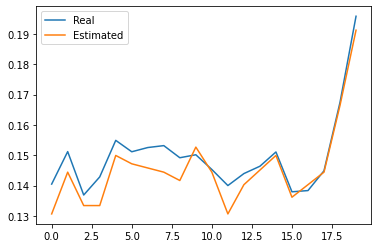

In [ ]:
range_history=np.arange(0,len(pc_test[:20]),1)

range_future=np.arange(0,len(pc_test[:20]),1)
plt.plot(range_history,GRUpred[:20,0],label="Real")
plt.plot(range_future,y_test[:20,0],label="Estimated")
plt.legend()

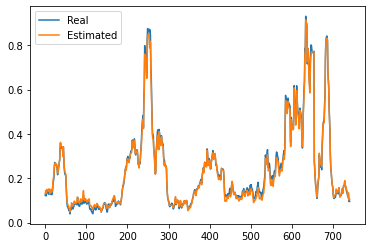

In [ ]:
range_history=np.arange(0,len(pc_test),1)

range_future=np.arange(0,len(pc_test[:]),1)
plt.plot(range_history,pcGRUpred[:,0],label="Real")
plt.plot(range_future,y_test[:,0],label="Estimated")
plt.legend()

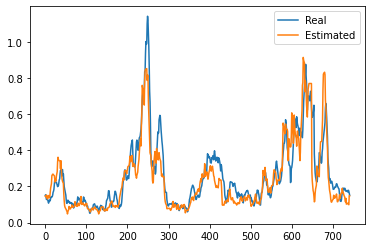

In [ ]:
range_history=np.arange(0,len(pc_test),1)

range_future=np.arange(0,len(pc_test[:]),1)
plt.plot(range_history,pcGRUpred[:,6],label="Real")
plt.plot(range_future,y_test[:,6],label="Estimated")
plt.legend()

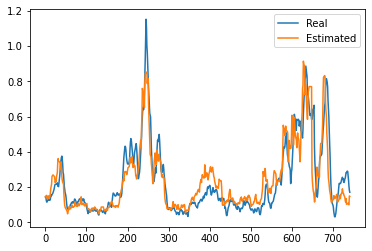

In [ ]:
range_history=np.arange(0,len(pc_test),1)

range_future=np.arange(0,len(pc_test[:]),1)
plt.plot(range_history,GRUpred[:,6],label="Real")
plt.plot(range_future,y_test[:,6],label="Estimated")
plt.legend()

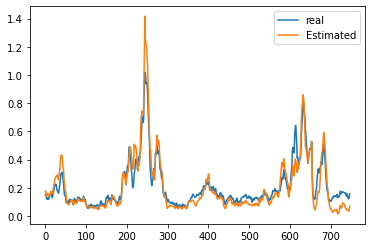

In [ ]:

y_test=y_test.flatten()
#y_pred=y_scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
#y_test=y_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
range_history=np.arange(0,len(pc_test),1)

range_future=np.arange(0,len(pc_test[:]),1)
plt.plot(range_history,pcGRUpred,label="real")
plt.plot(range_future,y_pred[:],label="Estimated")
plt.legend()

In [ ]:
nonpc_pred=model2.predict(nonpc_test).flatten()
plt.plot(range_history,y_test,label="real")
plt.plot(range_future,nonpc_pred[:],label="Estimated") 
plt.legend()

ValueError: ignored

(5479, 37)